In [1]:
from sympy import symbols, init_printing, pi, sqrt, solveset, Eq
from scipy.constants import c
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from ipywidgets.widgets import (
    interactive_output,
    BoundedFloatText,
    BoundedIntText,
    HBox,
    VBox,
    IntRangeSlider,
    Text,
    Button,
    Label,
    Layout,
    Checkbox
)
from ipywidgets import interact

from IPython.display import display
import datetime, os
from os.path import isdir
from pathlib import Path

In [2]:
init_printing()
save_location = Path(r"D:\SurfDrive\backup_for_surfacePro\Work\THz_setup\Simulations")

# Defining functions
def ghz_cm(x):
    """
    Input: freq in GHZ
    Output: freq in cm
    """
    return c * 1e2 / x * 1e-9

cm_ghz = lambda x: c*1e-9*1e2/x

print(f"Save location: {save_location}")
save_location.exists()

Save location: D:\SurfDrive\backup_for_surfacePro\Work\THz_setup\Simulations


True

In [3]:
# Symbols
w, lam, w0, z, Z_r = symbols("w, lam, w0, z, Z_r")
M, E, d_in, d_out, w0_in, w0_out, f, f0 = symbols('M, E, d_in, d_out, w0_in, w0_out, f, f0')

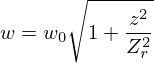

In [4]:
## Formulas

# Beam radius
Wz = Eq(w, w0 * sqrt(1 + (z / Z_r) ** 2))
Wz

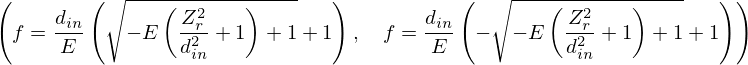

In [5]:
# Focal length
fp = Eq(f, Z_r*(d_in/(E*Z_r))*(1+sqrt(1-E*(1+(d_in/Z_r)**-2)))) # positive sign but output is negative focus
fm = Eq(f, Z_r*(d_in/(E*Z_r))*(1-sqrt(1-E*(1+(d_in/Z_r)**-2)))) # negative sign but output is positive focus

fp, fm

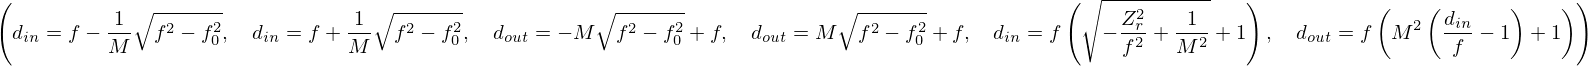

In [6]:
# Input distance
eq_din_m = Eq(d_in, f - sqrt(f ** 2 - f0 ** 2) / M) # Negative sign
eq_din_p = Eq(d_in, f + sqrt(f ** 2 - f0 ** 2) / M) # Positive sign

# output distance
eq_dout_m = Eq(d_out, f - sqrt(f ** 2 - f0 ** 2) * M) # Negative sign
eq_dout_p = Eq(d_out, f + sqrt(f ** 2 - f0 ** 2) * M) # Positive sign
# NOTE: use same sign for output distance as chosed for input distane

# Input and output distances in-terms of each other
eq_dout2 = Eq(d_out, f * (1 + (M ** 2 * (d_in / f - 1))))
eq_din2 = Eq(d_in, f * (1 + sqrt(M ** -2 - (Z_r / f) ** 2)))

eq_din_m, eq_din_p, eq_dout_m, eq_dout_p, eq_din2, eq_dout2, 

In [12]:
class gaussian_simulation:
   
    def __init__(self):

        W = BoundedFloatText(value=0.34, min=0.1, max=1, step=0.01, description="w0:")
        L = IntRangeSlider(
            value=[325, 1100], min=50, max=1500, step=1, description="GHz"
        )
        
        width = BoundedIntText(value=7, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=5, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=200, min=70, max=250, step=1, description="Dpi")

        entry1 = BoundedFloatText(
            value=-9, min=-11, max=10, step=0.1, description="Entry1"
        )
        Mirror = BoundedIntText(value=11, min=10, max=20, step=1, description="Mirror Position")
        
        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([W, L])
        row2 = HBox([width, height, dpi])
        row3 = HBox([entry1, Mirror])

        out = interactive_output(
            self.simulate,
            {
                "w0_": W,
                "wn": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "entry1": entry1,
                "mirror":Mirror
            },
        )

        display(
            VBox(
                [row1, row2, row3, out, self.save_name, save_button, self.print_save]
            )
        )

    def save_plot(self, event):
        if not isdir('./Simulations'):
            os.mkdir('./Simulations')

        self.fig0.savefig(f"./Simulations/{self.save_name.value}.png")
        self.fig0.savefig(f"./Simulations/{self.save_name.value}.pdf")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

    def beam_plot(self, ax, w0_, wn):
               
        self.gaussian_beam(w0_, wn)
        
        markers = '--'
        line_width = 1
        alpha = 0.7

        for c, beam in enumerate(self.beams):
            color = f"C{c}"
            ax.plot(
                z_,
                beam,
                markers+color, lw=line_width, alpha=alpha,
                label=f"{self.wn[c]:.2f} GHz ({ghz_cm(self.wn[c])*10:.2f} mm)",
                zorder=1
            )
            ax.plot(-z_, -beam, markers+color, lw=line_width, alpha=alpha, zorder=1)
            ax.plot(-z_, beam, markers+color, lw=line_width, alpha=alpha, zorder=1)
            ax.plot(z_, -beam, markers+color, lw=line_width, alpha=alpha, zorder=1)

    def simulate(self, w0_, wn, width, height, dpi, entry1, mirror):
        
        entry1 = round(entry1, 1)
        entry2 = round(10.4 - abs(entry1), 1)

        self.fig0, ax0 = plt.subplots(figsize=(width, height), dpi=dpi)
        self.beam_plot(ax0, w0_, wn)

        ax0.hlines(0, xmin=-z_.max(), xmax=z_.max())

        ## Annotation begins
        
        fontsz = 6

        # Distance b/w two entry points
        ax0.hlines(-0.2, xmin=entry1, xmax=entry2)
        plt.annotate(
            s=f"d={(entry2-entry1)}",
            xy=(0, 0),
            xytext=(-3, -0.1),
            ha="center",
            va="center",
            fontsize=fontsz
        )

        # Annotate beam waist
        ax0.vlines(x=0, ymin=0, ymax=w0_)
        '''plt.annotate(
            s="$w_0^{in}$=%.2f cm"%w0_,
            xy=(0, w0_+0.2),
            xytext=(0, 0.8),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )'''

        # Annotate Entry1
        ax0.vlines(x=entry1, ymin=-1, ymax=1)

        '''plt.annotate(
            s="Main entry window:\ndiameter=2cm",
            xy=(entry1, 1),
            xytext=(entry1 + 6, 1.1),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )'''

        # Annotate Entry2
        ax0.vlines(x=entry2, ymin=-0.43, ymax=0.43)

        '''plt.annotate(
            s="Trap bender entry:\ndiameter=0.86cm",
            xy=(entry2, -0.43),
            xytext=(entry2 - 3, -0.8),
            ha="center",
            va="center",
            # rotation = 30,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )'''
        
        # Inner entry: diameter: 0.64cm
        ax0.vlines(x=entry2+0.7, ymin=-0.32, ymax=0.32)

        # Annotate z-position

        plt.annotate(s="z=0", xy=(0, 0), xytext=(0, -0.05), ha="center", va="center",fontsize=fontsz)

        '''plt.annotate(
            s=f"z={entry1}",
            xy=(entry1, 0),
            xytext=(entry1 - 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )'''
        
        # d_in window
        mirror_pos = entry1-mirror
        ax0.vlines(x=mirror_pos, ymin=-self.beams.max(), ymax=self.beams.max())
        
        '''plt.annotate(
            s="Mirror($d_{in}$) at %.1f cm"%mirror_pos,
            xy=(mirror_pos+5, -self.beams.max()),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )'''

        ## Annotation ends

        ax0.set_xlabel("z direction : Beam Propagation (cm)")
        ax0.set_ylabel("w(z) : Gaussian Beam radius (cm)")
        ax0.set_title(f"Gaussian Beam simulation: {wn[0]}-{wn[-1]} GHz")
        ax0.legend(bbox_to_anchor=(0.16, 0.86), ncol=3, fontsize=5)
        ax0.xaxis.set_minor_locator(AutoMinorLocator())
        
        plt.show()
        # plt.close()

        self.save_name.value = f"{w0_}cm-{wn[0]}-{wn[-1]}GHz_simulation"

    def gaussian_beam(self, w0_, wn):
        
        global z_
        z_ = np.linspace(0, 25, 10)

        self.wn = np.linspace(*wn, 10)
        
        beams = []
        for l in self.wn:
            temp = []
            zr = np.pi*w0_**2/ghz_cm(l)
            temp = np.array([float(
                    Wz.subs({w0:w0_, Z_r:zr, z:i}).rhs
                ) for i in z_])
        
            beams.append(temp)
            
        self.beams = np.array(beams)
        
start = gaussian_simulation()

In [58]:
class simulation:
    def __init__(self):

        # Beam properties

        W_in = BoundedFloatText(
            value=0.34, min=0.1, max=1, step=0.01, description="$w0_{in}$: "
        )

        D_in = BoundedFloatText(
            value=20, min=5, max=30, step=0.1, description="$d_{in}$: "
        )

        btn_pxl = 300
        L1 = Text(value="325-500", description="GHz", layout={"width": f"{btn_pxl}px"})

        L2 = Text(value="500-750", description="GHz", layout={"width": f"{btn_pxl}px"})

        L3 = Text(value="750-1100", description="GHz", layout={"width": f"{btn_pxl}px"})

        W_out1 = BoundedFloatText(
            value=0.15, min=0.01, max=1, step=0.001, description="$w0_{out}$: "
        )

        W_out2 = BoundedFloatText(
            value=0.099, min=0.01, max=1, step=0.001, description="$w0_{out}$: "
        )

        W_out3 = BoundedFloatText(
            value=0.066, min=0.01, max=1, step=0.001, description="$w0_{out}$: "
        )

        f_manual = Checkbox(value=False, description="f_manual")

        # Figure Properties
        Width = BoundedFloatText(value=15, min=5, max=25, step=1, description="width")
        Height = BoundedFloatText(value=6, min=5, max=25, step=1, description="height")
        Dpi = BoundedFloatText(value=100, min=70, max=300, step=1, description="Dpi")

        # Widget to save
        self.save_name = Text(value="THz_simulation_325-1100GHz")
        save_button = Button(description="Save", layout={"width": "300px"})
        save_button.on_click(self.save_plot)
        self.print_save = Label(value="Status: ")

        # Widget arrangements
        row1 = HBox([W_in, D_in])
        row2 = HBox([Width, Height, Dpi])
        row3 = HBox([L1, L2, L3])
        row4 = HBox([W_out1, W_out2, W_out3])
        row5 = VBox([self.save_name, save_button, self.print_save])

        # Plot output
        out = interactive_output(
            self.plot,
            {
                "w1": W_in,
                "d1": D_in,
                "l1": L1,
                "l2": L2,
                "l3": L3,
                "wout1": W_out1,
                "wout2": W_out2,
                "wout3": W_out3,
                "width": Width,
                "height": Height,
                "dpi": Dpi,
            },
        )

        # widget display
        display(VBox([row1, row2, row3, row4, out, row5]))

    def save_plot(self, event):

        try:
            if not save_location.exists():
                save_location.mkdir()

            self.fig.savefig(save_location.joinpath(self.save_name.value + ".png"))
            self.fig.savefig(save_location.joinpath(self.save_name.value + ".pdf"))

            self.fig.savefig(f"./Simulations/{self.save_name.value}.png")
            self.fig.savefig(f"./Simulations/{self.save_name.value}.pdf")

            t = datetime.datetime.now()
            self.print_save.value = (
                f'File "{self.save_name.value}.png" Saved; {t.ctime()}'
            )

        except:
            self.print_save.value = "Error Occured."

    def plot(self, w1, d1, l1, l2, l3, wout1, wout2, wout3, width, height, dpi):

        wn_size = 5
        wz_size = 20
        d_trap = -1.4

        to_use = 0

        ##########################################################################################

        # opening log file

        if not isdir("./Simulations"):
            os.mkdir("./Simulations")
        t = datetime.datetime.now()
        log_file = open(f"./Simulations/log_file_{to_use}.txt", "w")
        log_file.write(f"Gaussian Simulation: {t.ctime()}\n\n")
        log_file.write(
            "##########################################################################################\n"
        )

        # 3-sets of wavelength range for 3-different horn
        l1 = tuple(np.array(l1.split("-"), dtype=np.int))
        l2 = tuple(np.array(l2.split("-"), dtype=np.int))
        l3 = tuple(np.array(l3.split("-"), dtype=np.int))

        wn_set1 = np.linspace(*l1, wn_size)
        wn_set2 = np.linspace(*l2, wn_size)
        wn_set3 = np.linspace(*l3, wn_size)
        wn_list = np.array([wn_set1, wn_set2, wn_set3])

        # 3-sets of horns waist for different wavelength
        w0_out_list = np.array([wout1, wout2, wout3])

        w0_out_in_use = w0_out_list[to_use]
        M_factor = w0_out_in_use / w1

        w0_in_list = w0_out_list / M_factor
        M_list = w0_out_list / w0_in_list

        # Focal length and d_out in-use (Taking optimal focal length for the longest wn)
        wn_in_use = wn_list[to_use, 0]
        M_in_use = M_list[to_use]

        zc_in_use = np.pi * w1 ** 2 / ghz_cm(wn_in_use)

        f_positive = float(
            fm.subs({d_in: d1, E: (1 - M_in_use ** -2), Z_r: zc_in_use}).rhs
        )
        f_negative = float(
            fp.subs({d_in: d1, E: (1 - M_in_use ** -2), Z_r: zc_in_use}).rhs
        )

        opt_d2 = float(eq_dout2.subs({f: f_positive, M: M_in_use, d_in: d1}).rhs)
        print(f_positive, opt_d2)

        log_file.write(
            f"\nFocii:\nf(+ve): {f_positive:.2f}; f(-ve): {f_negative:.2f}\n\n"
        )

        ##########################################################################################

        # Defining figure:
        self.fig, (ax1, ax2) = plt.subplots(
            nrows=1, ncols=2, sharey=True, figsize=(width, height), dpi=dpi
        )

        for ax in self.fig.axes:
            ax.grid()

        colors = "C0, C1, C2, C3, C4, C5, C6, C7, C8, C9".split(", ")
        mrkr = [".-", "x-", "--"]

        d1_beam = []
        d2_beam = []

        d1_distance = []
        d2_distance = []

        ##########################################################################################
        log_file.write(
            "##########################################################################################\n\n"
        )

        for num in range(len(w0_out_list)):

            log_file.write(f"w0_out: {w0_out_list[num]}cm\n\n")

            d1_beam_temp = []
            d2_beam_temp = []

            d1_distance_temp = []
            d2_distance_temp = []

            #################################################################################

            for c, wn in enumerate(wn_list[num]):

                log_file.write(f"Frequency: {wn}GHz\n")

                #################################################################################
                # optimised calculation
                temp_f0 = (np.pi * w0_in_list[num] * w0_out_list[num]) / ghz_cm(wn)

                temp_d1 = float(
                    eq_din_p.subs({M: M_list[num], f0: temp_f0, f: f_negative}).rhs
                )
                temp_d2 = float(
                    eq_dout_p.subs({M: M_list[num], f0: temp_f0, f: f_positive}).rhs
                )

                #################################################################################
                # d_in beam optimised
                d1_beam_array = np.linspace(temp_d1 - d1 + d_trap, temp_d1, wz_size)
                zr1 = (np.pi * w0_in_list[num] ** 2) / ghz_cm(wn)

                d1_beam_calculation = np.array(
                    [
                        float(Wz.subs({w0: w0_in_list[num], Z_r: zr1, z: i}).rhs)
                        for i in d1_beam_array
                    ]
                )

                #################################################################################
                # d_out beam optimised
                d2_beam_array = np.linspace(0, temp_d2, wz_size)
                zr2 = (np.pi * w0_out_list[num] ** 2) / ghz_cm(wn)

                d2_beam_calculation = np.array(
                    [
                        float(Wz.subs({w0: w0_out_list[num], Z_r: zr2, z: i}).rhs)
                        for i in d2_beam_array
                    ]
                )

                #################################################################################

                # Plotting
                d1_plot = np.linspace(d_trap, d1, wz_size)
                d2_plot = np.linspace(opt_d2 - temp_d2, opt_d2, wz_size)

                ax1.plot(
                    d2_plot,
                    d2_beam_calculation,
                    colors[c] + mrkr[num],
                    zorder=1,
                    label=f"{wn:.1f}GHz",
                )
                ax1.plot(d2_plot, -d2_beam_calculation, colors[c] + mrkr[num], zorder=1)

                ax2.plot(d1_plot, d1_beam_calculation, colors[c] + mrkr[num], zorder=1)
                ax2.plot(d1_plot, -d1_beam_calculation, colors[c] + mrkr[num], zorder=1)

                #################################################################################
                # Writing log file
                log_file.write(
                    f"d_in:\n{d1_beam_array}\nd_in_beam: {d1_beam_calculation}\n\n"
                )
                log_file.write(
                    f"d_out:\n{d2_beam_array}\nd_out_beam: {d2_beam_calculation}\n\n"
                )

                #################################################################################
                # Appending temp values
                d1_distance_temp.append(temp_d1)
                d2_distance_temp.append(temp_d2)

                d1_beam_temp.append(d1_beam_calculation)
                d2_beam_temp.append(d2_beam_calculation)

                #################################################################################
            #####################################################################################
            log_file.write(
                "##########################################################################################\n\n"
            )

            # Appending main values
            d1_distance.append(d1_distance_temp)
            d2_distance.append(d2_distance_temp)

            d1_beam.append(d1_beam_temp)
            d2_beam.append(d2_beam_temp)

            ######################################################################################
        ##########################################################################################
        # Making array
        d1_distance = np.array(d1_distance)
        d2_distance = np.array(d2_distance)

        d1_beam = np.array(d1_beam)
        d2_beam = np.array(d2_beam)

        ##########################################################################################
        log_file.write(f"w0_in_list: {w0_in_list}\n\n")
        log_file.write(f"w0_out_list: {w0_out_list}\n\n")
        log_file.write(f"Frequency list:\n{wn_list}\n\n")
        log_file.write(f"d_out: (Calibrated)\n{d2_distance}\n\n")
        log_file.write(f"d_in: (Calibrated)\n{d1_distance}\n\n")
        log_file.write(
            f"Mirror Diameter: >= {3*d1_beam[0, 0, -1]:.2f}cm\n(since longest wavelength beam waist at mirror is {d1_beam[0, 0, -1]:.2f}cm)\n\n"
        )

        ##########################################################################################
        # ax1
        ax1.set_xlim(xmax=opt_d2)

        ax1.set(
            xlabel="$d_{out}$ (cm)",
            ylabel="$w(z)$ cm",
            title=f"THz source to Mirror w0_out: {w0_out_list} cm",
        )
        ax1.legend(ncol=3)

        ax1.xaxis.set_minor_locator(AutoMinorLocator(10))

        ##########################################################################################
        # ax2
        ax2.invert_xaxis()
        ax2.set_xlim(xmin=d1)

        ax2.set(xlabel="$d_{in}$ (cm)", title="Mirror to trap")
        ax2.legend(
            title=f"f_+ = {f_positive:.2f}cm\nf_- = {f_negative:.2f}cm\nMirror Diameter: >= {3*d1_beam[0, 0, -1]:.2f}cm"
        )

        ax2.xaxis.set_minor_locator(AutoMinorLocator(10))

        # vlines
        ax2.vlines(0, ymin=-w1, ymax=w1)
        ax2.vlines(d_trap, ymin=-0.43, ymax=0.43)

        ##########################################################################################

        plt.tight_layout()

        ##########################################################################################
        log_file.write(
            "##########################################################################################\n"
        )
        log_file.write(
            "##########################################################################################\n\n"
        )

        log_file.close()
        ##########################################################################################
        self.save_name.value = f"THz_simulation_{l1[0]}-{l3[-1]} GHz_{to_use}"


run = simulation()

In [9]:
def func(t):
    print(t, type(t))
    temp = tuple(np.array(t.split("-"), dtype=np.int))
    print(temp, type(temp))

t1 = Text(value="1- 2", layout={"width": "100px"})
out = interactive_output(func, {"t":t1})

display(t1, out)

Text(value='1- 2', layout=Layout(width='100px'))

Output()

In [10]:
os.getcwd()

'D:\\FELion-Spectrum-Analyser\\Simulations\\THz'

In [30]:
M1 = 0.15/0.34


In [50]:
M1 = 0.15 / 0.34
zc_1 = np.pi * 0.34 ** 2 / ghz_cm(325)

f_positive = float(fm.subs({d_in: 20, E: (1 - M1 ** -2), Z_r: zc_1}).rhs)
f_negative = float(fp.subs({d_in: 20, E: (1 - M1 ** -2), Z_r: zc_1}).rhs)

temp_f0 = (np.pi * 0.15 * 0.34) / ghz_cm(325)

f_negative, f_positive

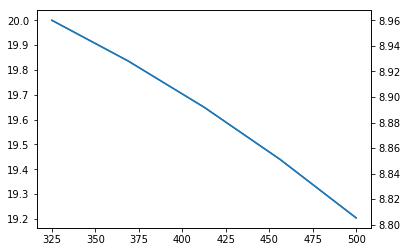

In [55]:
f_1 = f_positive
temp_d1 = [float(eq_din_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_1}).rhs) for i in np.linspace(325, 500, 5)]
temp_d2 = [float(eq_dout_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_1}).rhs) for i in np.linspace(325, 500, 5)]

fig, ax = plt.subplots()
ax.plot(np.linspace(325, 500, 5), temp_d1)
ax.twinx().plot(np.linspace(325, 500, 5), temp_d2)

temp_d1, temp_d2

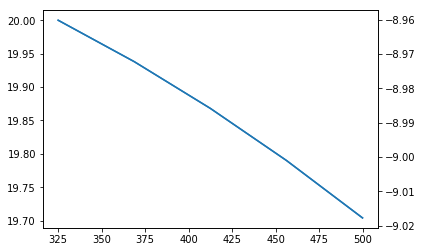

In [56]:
f_1 = f_negative
temp_d1 = [float(eq_din_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_1}).rhs) for i in np.linspace(325, 500, 5)]
temp_d2 = [float(eq_dout_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_1}).rhs) for i in np.linspace(325, 500, 5)]

fig, ax = plt.subplots()
ax.plot(np.linspace(325, 500, 5), temp_d1)
ax.twinx().plot(np.linspace(325, 500, 5), temp_d2)

temp_d1, temp_d2

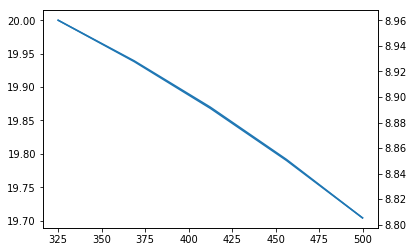

In [57]:
temp_d1 = [float(eq_din_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_negative}).rhs) for i in np.linspace(325, 500, 5)]
temp_d2 = [float(eq_dout_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_positive}).rhs) for i in np.linspace(325, 500, 5)]

fig, ax = plt.subplots()
ax.plot(np.linspace(325, 500, 5), temp_d1)
ax.twinx().plot(np.linspace(325, 500, 5), temp_d2)

temp_d1, temp_d2

In [72]:
[float(eq_din_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_negative}).rhs) for i in np.linspace(325, 1100, 5)], [float(eq_din_p.subs({M: M1, f0: (np.pi * 0.15 * 0.34) / ghz_cm(i), f: f_positive}).rhs) for i in np.linspace(325, 1100, 5)]